# Learning the ceritificate and partitioning

In [222]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import pandas as pd

from envs import SimpleEnv

In [530]:
class ReachNN(nn.Module):
  def __init__(self):
    super(ReachNN, self).__init__()
    self.fc1 = nn.Linear(2, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x 

In [563]:
env = SimpleEnv(alpha=0.5, beta=0.5)
net = ReachNN()

# 5000 2-dimensional samples from the state space.
x = torch.rand(5000, 2)*2 - 1

tgt_mask = torch.logical_and(
    torch.abs(x[:,0]) <= 0.05,
    torch.abs(x[:,1]) <= 0.05,
)

# Partitioning samples to target and decrease sets.
x_tgt = x[tgt_mask]
x_dec = x[~tgt_mask] 
print(f'|x_dec|={len(x_dec)}, |x_tgt|={len(x_tgt)}')

|x_dec|=4989, |x_tgt|=11


In [570]:
def loss_fn(net, x_tgt, x_dec):
    return 1*loss_tgt(net, x_tgt) + 32*loss_dec(net, x_dec)

def loss_tgt(net, x_tgt):
    N = len(x_tgt)
    return 1/N * torch.sum(
        torch.relu(net(x_tgt) - 0.3)
    )

# Tunable hyperparameters for learning: eps, lr

def loss_dec(net, x_dec, eps=1e-2):
    f = torch.vmap(env.f)
    x_nxt = f(x_dec)
    
    zero = torch.zeros(x_dec.shape)
    N = len(x_dec)
    return 1/N * torch.sum(
        torch.maximum(net(x_nxt) - net(x_dec) + eps, zero)
    )

optimizer = optim.Adam(net.parameters(), lr=2e-3, weight_decay=1e-4)

for iter in range(1024):
    optimizer.zero_grad()
    loss = loss_fn(net, x_tgt, x_dec)
    if iter % 128 == 0:
        print(f'{iter:>3}. Loss={loss.item()}')
    loss.backward()
    optimizer.step()

  0. Loss=0.0008566804463043809
128. Loss=2.9020402507740073e-05
256. Loss=2.419692918920191e-06
384. Loss=1.0800758900586516e-06
512. Loss=1.0370037671236787e-05
640. Loss=1.9815647078758047e-07
768. Loss=0.0
896. Loss=3.808174142250209e-06


Text(0, 0.5, '$V \\circ f$')

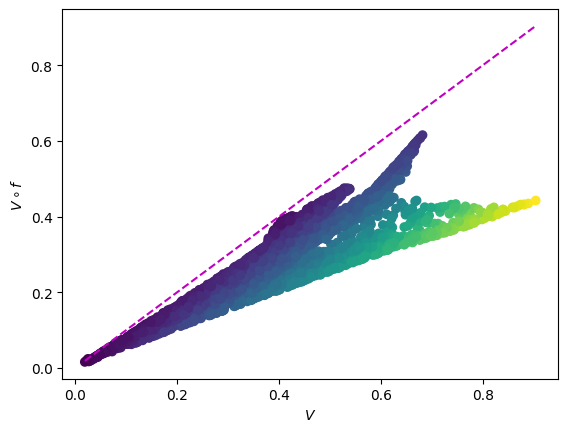

In [571]:
v = net(x)
vf = net(torch.vmap(env.f)(x))
v, vf = v.detach(), vf.detach()
plt.plot(
    [torch.min(v), torch.max(v)], [torch.min(v), torch.max(v)], 'm--')
plt.scatter(v, vf, c=torch.relu(v-vf))
plt.xlabel(r'$V$')
plt.ylabel(r'$V \circ f$')

Text(0, 0.5, '$x_1$')

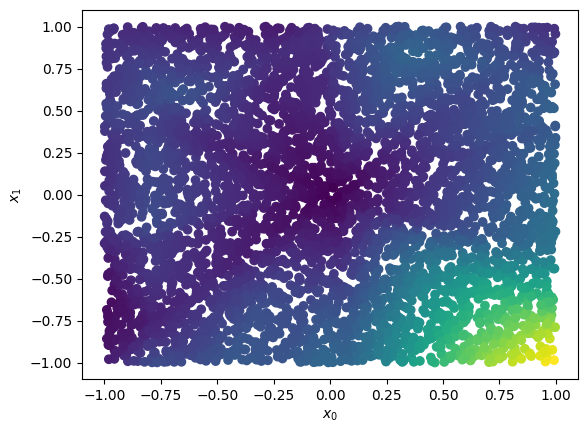

In [572]:
plt.scatter(x[:,0], x[:,1],c=torch.relu(v-vf))
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')

In [479]:
def binary_search(a, n, f):
    l, r = -1, n
    while r-l > 1:
        m = (l+r) >> 1
        if f(a[m]):
            l = m
        else:
            r = m
    return r

def partition(x: torch.Tensor, v, f):
    vx = v(x)
    vfx = v(f(x))
    
    # Assumption. The learned certificate does not violate the 
    # decrease condition on its training data.
    
    # assert torch.all(vx > vfx)
    
    vx, sort_idx = torch.sort(vx, dim=0)
    x, vfx = x[sort_idx,:], vfx[sort_idx,:]
    x, vfx = torch.squeeze(x), torch.squeeze(vfx)
    # print(x,vx,vfx)
    
    # shapes:
    #   x:   Nx2
    #   vx:  Nx1 
    #   vfx: Nx1
    
    # A list of all partitions
    P = []
    N = len(x)
    for i in range(1, N):
        if vfx[i] >= vx[i]:
            continue
        if i % 100 == 0:
            print(f'i={i}. |P|={len(P)}')
        # TODO: try binary search for log(|P|) search
        idx = binary_search(P, len(P), lambda p: vfx[i] < p[0][2])
        # for p in P:
            # if vfx[i] < p[0][2]:
                # p.append((x[i], vx[i], vfx[i]))
                # break
        if idx == len(P):
            P.append([(x[i], vx[i], vfx[i])])
        else:
            P[idx].append((x[i], vx[i], vfx[i]))
        
    print(len(P))

partition(x, net, torch.vmap(env.f))

i=100. |P|=5
i=700. |P|=11
i=900. |P|=12
i=1100. |P|=14
i=1300. |P|=15
i=1400. |P|=16
i=1500. |P|=16
i=1600. |P|=17
i=1700. |P|=17
i=1800. |P|=17
i=1900. |P|=17
i=2100. |P|=17
i=2200. |P|=17
i=2400. |P|=17
i=2500. |P|=17
i=2600. |P|=17
i=2700. |P|=17
i=2800. |P|=17
i=3000. |P|=17
i=3100. |P|=17
i=3200. |P|=17
i=3300. |P|=17
i=3500. |P|=17
i=3600. |P|=17
i=3700. |P|=17
i=3800. |P|=17
i=3900. |P|=17
i=4000. |P|=17
i=4100. |P|=17
i=4200. |P|=17
i=4300. |P|=17
i=4400. |P|=17
i=4500. |P|=17
i=4600. |P|=17
i=4700. |P|=17
i=4800. |P|=17
i=4900. |P|=17
17
